In [ ]:
import numpy as np
import evaluator as ev

In [ ]:
import data_loader as dl
import importlib
importlib.reload(dl)
matches = dl.load_data()
matches

In [ ]:
def prepare_data(df):
    df = df.rename(columns={ 'winner': 'winner_label', 'outcome': 'outcome_label' }) if 'winner' in df.columns else df

    train_seasons = list(range(df['season'].min(), 2023))
    test_seasons = list(range(2023,df['season'].max() +1))
    print(train_seasons, test_seasons)
    train_df = df[df['season'].isin(train_seasons)].copy()
    test_df = df[df['season'].isin(test_seasons)].copy()
    label_map = {'H_or_D':0,'A':1}

    train_df = create_features(train_df, label_map)
    test_df = create_features(test_df, label_map)

    features = [
        'elo_home_pre','elo_away_pre','elo_diff_pre',
        'home_gf_roll','home_ga_roll','home_pts_roll',
        'away_gf_roll','away_ga_roll','away_pts_roll',
        'rest_days_home','rest_days_away','rest_days_diff'
    ]

    x_train = train_df[features]
    y_train = train_df['target']

    x_test = test_df[features]
    y_test = test_df['target']

    return x_train, y_train, x_test, y_test, test_df, label_map, features

In [ ]:
from sklearn.ensemble import RandomForestClassifier
def predict_random_forest(df):

    x_train, y_train, x_test, y_test, test_df, label_map, features = pp.prepare_data(df)

    rf_model = RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        random_state=42,
        class_weight='balanced',
    )

    rf_model.fit(x_train, y_train)
    #Predict with RandomForestClassifier the probability of H_or_D or A
    prob = rf_model.predict_proba(x_test)
    pred_labels = np.argmax(prob, axis=1)


    ev.evaluate(y_test, prob, pred_labels, test_df, label_map, features, rf_model.feature_importances_)

In [ ]:
importlib.reload(pp)
importlib.reload(ev)
predict_random_forest(matches)

In [24]:
import lightgbm as lgb
def predict_lightgbm(df):
    x_train, y_train, x_test, y_test, test_df, label_map, features = pp.prepare_data(df)

    params = {
        'objective': 'multiclassova',
        'num_class': 2,
        'metric': 'multi_logloss',
        'verbosity': -1,
        'seed': 42,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'min_data_in_leaf': 20
    }
    lgb_tr = lgb.Dataset(x_train, label=y_train)
    gbm = lgb.train(params, lgb_tr, num_boost_round=1000)
    model = gbm


    preds = model.predict(x_test)
    pred_labels = np.argmax(preds, axis=1)
    ev.evaluate(y_test, preds, pred_labels, test_df, label_map, features, model.feature_importance(importance_type='gain'))

[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022] [2023, 2024, 2025]
logloss: 0.5575434816201174
accuracy: 0.8156996587030717
Confusion matrix (rows true, cols pred):
[[519  72]
 [ 90 198]]
Precision: 0.7927750410509031
Recall: 0.7828362944162437


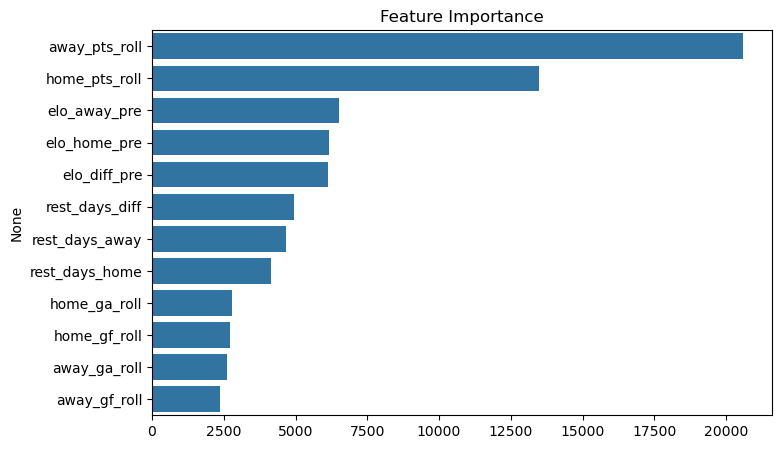

In [25]:
importlib.reload(pp)
importlib.reload(ev)
predict_lightgbm(matches)

In [ ]:
from xgboost import XGBClassifier
def predict_xgboost(df):
    x_train, y_train, x_test, y_test, test_df, label_map, features = pp.prepare_data(df)

    xgb_model = XGBClassifier(
        n_estimators=500,
        num_class=2,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        objective='multi:softprob',  # for multiclass probability output
        eval_metric='mlogloss'       # multi-class log loss
    )

    # Fit model
    xgb_model.fit(x_train, y_train)

    # Predict probabilities
    prob = xgb_model.predict_proba(x_test)
    pred_labels = np.argmax(prob, axis=1)
    feature_importances = xgb_model.get_booster().get_score(importance_type='gain')

    # Evaluate model
    ev.evaluate(y_test, prob, pred_labels, test_df, label_map, features, feature_importances)

In [ ]:
importlib.reload(pp)
importlib.reload(ev)
predict_xgboost(matches)